# Optional exercise week 3: Implement a convolutional neural network

IN3310 / IN4310 - Machine Learning for Image Analysis

---

You will later in this course implement convolutional neural networks. If you want to get started already now, then try to update the code you implemented in exercise part 1 ("Exercises week 3 part 1: Implement a dense neural network") to use a convolutional neural network instead of a dense neural network:

- We recommend that you proceed by making a copy of your solution of exercise part 1 and modify the "Model" class to use some convolutional layers and then one or a few fully-connected layers at the end. You do not need to copy the "utils" folder and any "data" folder if you place the copy of your solution of exercise part 1 in the same folder. As the 28x28 images are being concatenated in "datasetFashionMNIST", the input to the class method "forward" in the "Model" class will still have the shape [batch size, 28x28], but you can simply reshape them back to images at the beginning of "forward", e.g. by using "out = x.reshape(x.size(0), 1, 28, 28)" and then process and return "out".

- You can use "nn.Conv2d" to create convolutional layers and "nn.MaxPool2d" to create pooling layers ("torch.nn" is imported as "nn"). Before you apply any fully-connected layers in the class method "forward" in the "Model" class, you should convert the activation map of each sample to a vector, e.g. by using "out = out.view(out.size(0), -1)".

- You may find it interesting to re-experiment with different values for the batch size, learning rate and number of epochs trained, all specified in the dictionary "config". You might also want to set "use_cuda" to "True" in "config" if you have a GPU available.

If you want to implement a convolutional neural network but do not want to modify your solution of exercise part 1, then you can instead modify the code below. It is based on a solution file of exercise part 1, but the "Model" class is modified and now raises NotImplementedError where you shall be coding.

---

## Play with MNIST Fashion and PyTorch

---
Your task is to use PyTorch to build a model and train a neural network on the MNIST Fashion dataset. Before you can start, you need to have access to the MNIST Fashion dataset. If you use an IFI computer, the default path given in this Jupyter Notebook file will root you to the data. If you work on any other computer, you will need to download the MNIST Fashion dataset. You can download the files from: https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion

MINST Fashion files:
- t10k-images-idx3-ubyte.gz
- t10k-labels-idx1-ubyte.gz
- train-images-idx3-ubyte.gz
- train-labels-idx1-ubyte.gz

Do not download the files with rightclick-save as in GitHub, but e.g. with left clicking and using the download button. If you get shape errors in the Dataset and your images files are only as few KBytes small, then you have not successfully downloaded the files.

The MNIST Fashion dataset have 10 classes: ['T-shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'].  

The training set consists of 60,000 images and the test set consists of 10,000 images. The images are of size [28,28].


**Important!**
You will need to add code only at locations where a NotImplementedError is raised.

<b>"%matplotlib inline"</b> is used to plot figures within Jupyter Notebook.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.utility_functions import datasetFashionMNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

%matplotlib inline

---
### Step 1: Handling of the data

The following cell creates two instances of "datasetFashionMNIST". The "datasetFashionMNIST" is a "torch.utils.data.Dataset" written for the MNIST Fashion dataset.

If you do not use an IFI computer, edit the "dataPath" to the location of the MNIST Fashion dataset.


In [2]:
#Path to the MNIST Fashion files
#dataPath = 'data/MNIST_fashion/'
dataPath = '/projects/in5400/MNIST_fashion/'

# Create dataset objects
train_dataset = datasetFashionMNIST(dataPath=dataPath, train=True)
val_dataset   = datasetFashionMNIST(dataPath=dataPath, train=False)


data/MNIST_fashion/train-labels-idx1-ubyte.gz (60000,)
data/MNIST_fashion/train-images-idx3-ubyte.gz (47040000,)
data/MNIST_fashion/t10k-labels-idx1-ubyte.gz (10000,)
data/MNIST_fashion/t10k-images-idx3-ubyte.gz (7840000,)


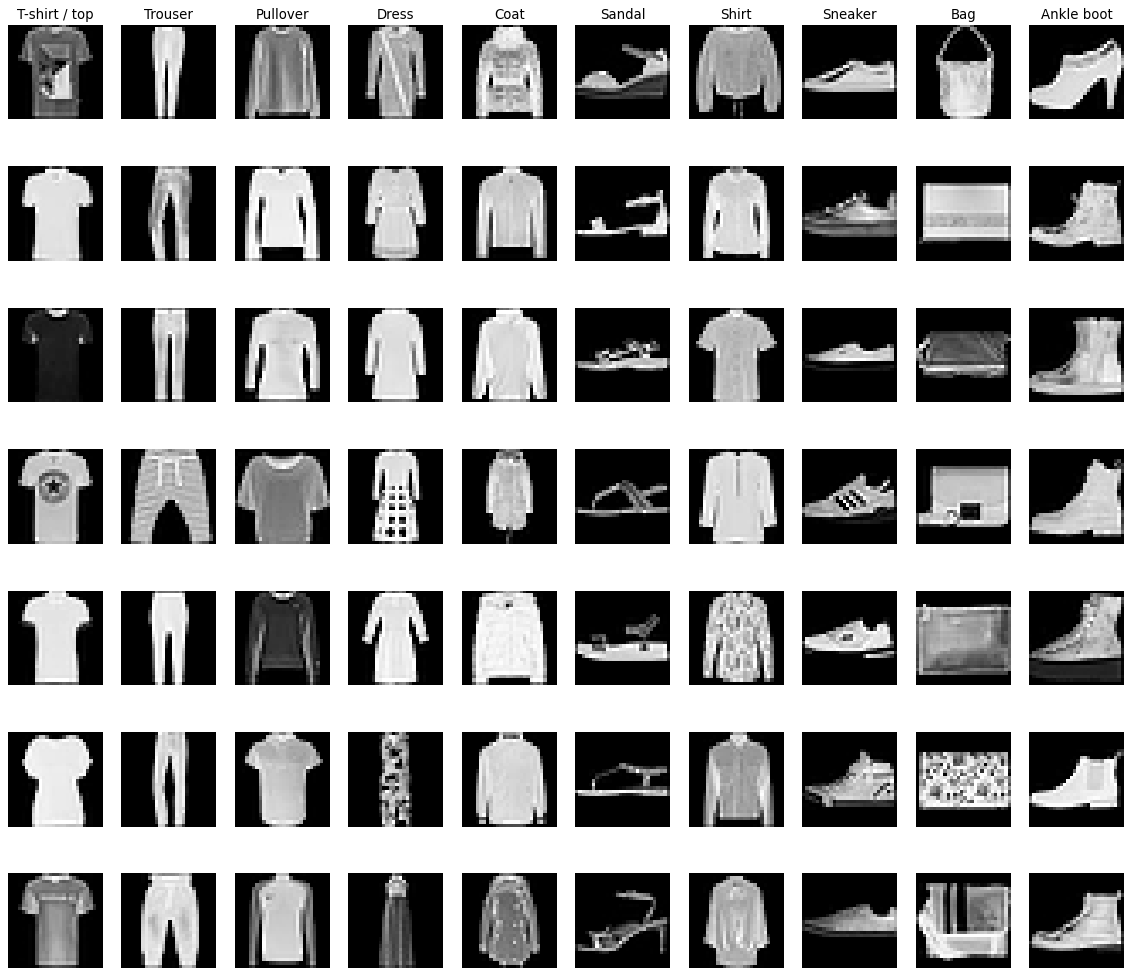

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['T-shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)
samples_per_class = 7
plt.figure(figsize=(18, 16), dpi=80)
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(np.array(train_dataset.labels) == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        img = (train_dataset.images[idx,:]).astype(np.uint8)
        img = np.resize(img, (28, 28))   # reshape to 28x28
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

---
To keep track of important parameters, we use dictionary "config". When you are done implementing the NotImplementedError's below, you may find it interesting to experiment with different values for the batch size, learning rate and number of epochs trained.

In [4]:
config = {
          'batch_size': 32,
          'use_cuda': True,       #True=use Nvidia GPU | False use CPU
          'log_interval': 100,    #How often to display (batch) loss during training
          'epochs': 100,          #Number of epochs
          'learningRate': 0.001
         }

We can iterate through the data with the instances of "datasetFashionMNIST". However, we will for convenience use PyTorch's "torch.utils.data.DataLoader" class as it helps us with batching and shuffling of the data. It also makes it possible to use multiple CPU cores/threads to speed up data preprocessing. Your task is to instantiate two data loaders (one for each of the training and validation dataset objects), using PyTorch's dataloader "torch.utils.data.DataLoader". Consider if you will use multiple workers and shuffling of data.

In [5]:
# DataLoaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

---
### Step 2: Build the model

You are now to define the network architecture. The code provided below defines a fully connected neural network (dense neural network) with two hidden layer of size 128 and 64. However, we encourage you to play with the network configuration.

The input has shape [batch size, 28x28]. The 28x28 image size are being concatenated in "datasetFashionMNIST". Try to change:
- The number of layers
- The size of the hidden layers
- The activation functions


Note that the model inherits from "torch.nn.Module", which requires the two class methods "__init__" and "forward". The former defines the layers used by the model, while the latter defines how the layers are stacked inside the model.


In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1,  out_channels=16, kernel_size=3, stride=1, padding=1)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.cnn3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.cnn5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.cnn6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*7*7, 10)

    def forward(self, x):
        out = x.reshape(x.size(0), 1, 28, 28)
        out = F.relu(self.cnn1(out))
        out = F.relu(self.cnn2(out))
        out = F.relu(self.cnn3(out))
        out = self.maxpool1(out)
        out = F.relu(self.cnn4(out))
        out = F.relu(self.cnn5(out))
        out = F.relu(self.cnn6(out))
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out


In [7]:
# Create an instance of Model
model = Model()
if config['use_cuda'] == True:
    model.to('cuda')

---
### Step 3: Define optimizer and loss function

Instantiate an optimizer, e.g. stochastic gradient descent, from the "torch.optim" module (https://pytorch.org/docs/stable/optim.html) with your model. Remember that we have defined "learning rate" inside the config-dictionary.


In [8]:
# Create an instance of "torch.optim.SGD"

optimizer = torch.optim.SGD(model.parameters(), lr = config['learningRate'])

---
Here we want to define the loss function (often called criterion). As we are dealing with a classification problem, the softmax cross entropy loss is an appropriate choice.

Hint, have a look here: (https://pytorch.org/docs/stable/nn.html#torch-nn-functional)

In [9]:
def loss_fn(prediction, labels):
    """Returns softmax cross entropy loss."""
    loss = F.cross_entropy(input=prediction, target=labels)
    return loss

---
### Step 4: Set up the training process and train the model

You now have all the building blocks needed to set up the training process. You will implement the function "run_epoch" which shall loop though a dataset and train the model.


In [10]:
def run_epoch(model, epoch, data_loader, optimizer, is_training, config):
    """
    Args:
        model        (obj): The neural network model
        epoch        (int): The current epoch
        data_loader  (obj): A pytorch data loader "torch.utils.data.DataLoader"
        optimizer    (obj): A pytorch optimizer "torch.optim"
        is_training (bool): Whether to use train (update) the model/weights or not. 
        config      (dict): Configuration parameters

    Intermediate:
        totalLoss: (float): The accumulated loss from all batches. 
                            Hint: Should be a numpy scalar and not a pytorch scalar

    Returns:
        loss_avg         (float): The average loss of the dataset
        accuracy         (float): The average accuracy of the dataset
        confusion_matrix (float): A 10x10 matrix
    """
    
    if is_training==True: 
        model.train()
    else:
        model.eval()

    total_loss       = 0 
    correct          = 0 
    confusion_matrix = np.zeros(shape=(10,10))
    labels_list      = [0,1,2,3,4,5,6,7,8,9]

    for batch_idx, data_batch in enumerate(data_loader):
        if config['use_cuda'] == True:
            images = data_batch[0].to('cuda') # send data to GPU
            labels = data_batch[1].to('cuda') # send data to GPU
        else:
            images = data_batch[0]
            labels = data_batch[1]

        if not is_training:
            with torch.no_grad():
                prediction = model(images)
                loss        = loss_fn(prediction, labels)
                total_loss += loss.item()    
            
        elif is_training:
            prediction = model(images)
            loss        = loss_fn(prediction, labels)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update the number of correct classifications and the confusion matrix
        predicted_label  = prediction.max(1, keepdim=True)[1][:,0]
        correct          += predicted_label.eq(labels).cpu().sum().numpy()
        confusion_matrix += metrics.confusion_matrix(labels.cpu().numpy(), predicted_label.cpu().numpy(), labels=labels_list)

        # Print statistics
        #batchSize = len(labels)
        if batch_idx % config['log_interval'] == 0:
            print(f'Epoch={epoch} | {(batch_idx+1)/len(data_loader)*100:.2f}% | loss = {loss:.5f}')

    loss_avg         = total_loss / len(data_loader)
    accuracy         = correct / len(data_loader.dataset)
    confusion_matrix = confusion_matrix / len(data_loader.dataset)

    return loss_avg, accuracy, confusion_matrix


---
Here is where the action takes place!

In [11]:
# train the model
train_loss = np.zeros(shape=config['epochs'])
train_acc  = np.zeros(shape=config['epochs'])
val_loss   = np.zeros(shape=config['epochs'])
val_acc    = np.zeros(shape=config['epochs'])
train_confusion_matrix = np.zeros(shape=(10,10,config['epochs']))
val_confusion_matrix   = np.zeros(shape=(10,10,config['epochs']))

for epoch in range(config['epochs']):
    train_loss[epoch], train_acc[epoch], train_confusion_matrix[:,:,epoch] = \
                               run_epoch(model, epoch, train_loader, optimizer, is_training=True, config=config)

    val_loss[epoch], val_acc[epoch], val_confusion_matrix[:,:,epoch]     = \
                               run_epoch(model, epoch, val_loader, optimizer, is_training=False, config=config)

Epoch=0 | 0.05% | loss = 2.30057
Epoch=0 | 5.39% | loss = 2.29623
Epoch=0 | 10.72% | loss = 2.29287
Epoch=0 | 16.05% | loss = 2.28904
Epoch=0 | 21.39% | loss = 2.28716
Epoch=0 | 26.72% | loss = 2.22749
Epoch=0 | 32.05% | loss = 2.29961
Epoch=0 | 37.39% | loss = 2.29684
Epoch=0 | 42.72% | loss = 2.26500
Epoch=0 | 48.05% | loss = 2.31639
Epoch=0 | 53.39% | loss = 2.10379
Epoch=0 | 58.72% | loss = 2.22332
Epoch=0 | 64.05% | loss = 2.13961
Epoch=0 | 69.39% | loss = 2.04891
Epoch=0 | 74.72% | loss = 1.83829
Epoch=0 | 80.05% | loss = 1.49506
Epoch=0 | 85.39% | loss = 1.17307
Epoch=0 | 90.72% | loss = 1.10293
Epoch=0 | 96.05% | loss = 1.13154
Epoch=0 | 0.32% | loss = 1.26424
Epoch=0 | 32.27% | loss = 4.51763
Epoch=0 | 64.22% | loss = 1.31640
Epoch=0 | 96.17% | loss = 1.04146
Epoch=1 | 0.05% | loss = 1.20262
Epoch=1 | 5.39% | loss = 1.10984
Epoch=1 | 10.72% | loss = 1.02668
Epoch=1 | 16.05% | loss = 0.91859
Epoch=1 | 21.39% | loss = 1.12076
Epoch=1 | 26.72% | loss = 1.55971
Epoch=1 | 32.05% | 

Epoch=10 | 64.05% | loss = 0.50576
Epoch=10 | 69.39% | loss = 0.29791
Epoch=10 | 74.72% | loss = 0.39658
Epoch=10 | 80.05% | loss = 0.97105
Epoch=10 | 85.39% | loss = 0.40601
Epoch=10 | 90.72% | loss = 0.67435
Epoch=10 | 96.05% | loss = 0.21267
Epoch=10 | 0.32% | loss = 0.53491
Epoch=10 | 32.27% | loss = 0.55301
Epoch=10 | 64.22% | loss = 0.52583
Epoch=10 | 96.17% | loss = 0.39630
Epoch=11 | 0.05% | loss = 0.32091
Epoch=11 | 5.39% | loss = 0.28526
Epoch=11 | 10.72% | loss = 0.93896
Epoch=11 | 16.05% | loss = 0.40387
Epoch=11 | 21.39% | loss = 0.48609
Epoch=11 | 26.72% | loss = 1.23268
Epoch=11 | 32.05% | loss = 0.27829
Epoch=11 | 37.39% | loss = 0.33084
Epoch=11 | 42.72% | loss = 0.40527
Epoch=11 | 48.05% | loss = 0.34317
Epoch=11 | 53.39% | loss = 0.18900
Epoch=11 | 58.72% | loss = 0.75656
Epoch=11 | 64.05% | loss = 0.55972
Epoch=11 | 69.39% | loss = 0.34994
Epoch=11 | 74.72% | loss = 0.36948
Epoch=11 | 80.05% | loss = 0.72071
Epoch=11 | 85.39% | loss = 0.33059
Epoch=11 | 90.72% | los

Epoch=20 | 90.72% | loss = 0.50544
Epoch=20 | 96.05% | loss = 0.34313
Epoch=20 | 0.32% | loss = 0.45528
Epoch=20 | 32.27% | loss = 0.45212
Epoch=20 | 64.22% | loss = 0.35836
Epoch=20 | 96.17% | loss = 0.26718
Epoch=21 | 0.05% | loss = 0.65922
Epoch=21 | 5.39% | loss = 0.18647
Epoch=21 | 10.72% | loss = 0.20321
Epoch=21 | 16.05% | loss = 0.48944
Epoch=21 | 21.39% | loss = 0.38792
Epoch=21 | 26.72% | loss = 0.40902
Epoch=21 | 32.05% | loss = 0.35077
Epoch=21 | 37.39% | loss = 0.64374
Epoch=21 | 42.72% | loss = 0.32520
Epoch=21 | 48.05% | loss = 0.34562
Epoch=21 | 53.39% | loss = 0.18276
Epoch=21 | 58.72% | loss = 0.41359
Epoch=21 | 64.05% | loss = 0.32403
Epoch=21 | 69.39% | loss = 0.26444
Epoch=21 | 74.72% | loss = 0.57262
Epoch=21 | 80.05% | loss = 0.19490
Epoch=21 | 85.39% | loss = 0.35166
Epoch=21 | 90.72% | loss = 0.32436
Epoch=21 | 96.05% | loss = 0.25129
Epoch=21 | 0.32% | loss = 0.49582
Epoch=21 | 32.27% | loss = 0.45340
Epoch=21 | 64.22% | loss = 0.39233
Epoch=21 | 96.17% | loss

Epoch=30 | 96.17% | loss = 0.21435
Epoch=31 | 0.05% | loss = 0.32231
Epoch=31 | 5.39% | loss = 0.37523
Epoch=31 | 10.72% | loss = 0.37128
Epoch=31 | 16.05% | loss = 0.31376
Epoch=31 | 21.39% | loss = 0.61820
Epoch=31 | 26.72% | loss = 0.53101
Epoch=31 | 32.05% | loss = 0.32739
Epoch=31 | 37.39% | loss = 0.25430
Epoch=31 | 42.72% | loss = 0.15231
Epoch=31 | 48.05% | loss = 0.43206
Epoch=31 | 53.39% | loss = 0.15072
Epoch=31 | 58.72% | loss = 0.14849
Epoch=31 | 64.05% | loss = 0.45462
Epoch=31 | 69.39% | loss = 0.55594
Epoch=31 | 74.72% | loss = 0.33754
Epoch=31 | 80.05% | loss = 0.18821
Epoch=31 | 85.39% | loss = 0.07462
Epoch=31 | 90.72% | loss = 0.40918
Epoch=31 | 96.05% | loss = 0.49805
Epoch=31 | 0.32% | loss = 0.43620
Epoch=31 | 32.27% | loss = 0.40167
Epoch=31 | 64.22% | loss = 0.35538
Epoch=31 | 96.17% | loss = 0.20500
Epoch=32 | 0.05% | loss = 0.16945
Epoch=32 | 5.39% | loss = 0.20619
Epoch=32 | 10.72% | loss = 0.23605
Epoch=32 | 16.05% | loss = 0.46357
Epoch=32 | 21.39% | loss 

Epoch=41 | 21.39% | loss = 0.35616
Epoch=41 | 26.72% | loss = 0.17923
Epoch=41 | 32.05% | loss = 0.20975
Epoch=41 | 37.39% | loss = 0.27177
Epoch=41 | 42.72% | loss = 0.24215
Epoch=41 | 48.05% | loss = 0.18590
Epoch=41 | 53.39% | loss = 0.20076
Epoch=41 | 58.72% | loss = 0.23671
Epoch=41 | 64.05% | loss = 0.28423
Epoch=41 | 69.39% | loss = 0.28854
Epoch=41 | 74.72% | loss = 0.32007
Epoch=41 | 80.05% | loss = 0.16848
Epoch=41 | 85.39% | loss = 0.22570
Epoch=41 | 90.72% | loss = 0.28403
Epoch=41 | 96.05% | loss = 0.61740
Epoch=41 | 0.32% | loss = 0.40407
Epoch=41 | 32.27% | loss = 0.39302
Epoch=41 | 64.22% | loss = 0.30533
Epoch=41 | 96.17% | loss = 0.21419
Epoch=42 | 0.05% | loss = 0.13809
Epoch=42 | 5.39% | loss = 0.41310
Epoch=42 | 10.72% | loss = 0.30442
Epoch=42 | 16.05% | loss = 0.26890
Epoch=42 | 21.39% | loss = 0.33978
Epoch=42 | 26.72% | loss = 0.20905
Epoch=42 | 32.05% | loss = 0.17705
Epoch=42 | 37.39% | loss = 0.54465
Epoch=42 | 42.72% | loss = 0.26546
Epoch=42 | 48.05% | los

Epoch=51 | 48.05% | loss = 0.18408
Epoch=51 | 53.39% | loss = 0.17088
Epoch=51 | 58.72% | loss = 0.13259
Epoch=51 | 64.05% | loss = 0.26282
Epoch=51 | 69.39% | loss = 0.30413
Epoch=51 | 74.72% | loss = 0.10697
Epoch=51 | 80.05% | loss = 0.21278
Epoch=51 | 85.39% | loss = 0.15602
Epoch=51 | 90.72% | loss = 0.16811
Epoch=51 | 96.05% | loss = 0.16420
Epoch=51 | 0.32% | loss = 0.40240
Epoch=51 | 32.27% | loss = 0.37193
Epoch=51 | 64.22% | loss = 0.28191
Epoch=51 | 96.17% | loss = 0.23623
Epoch=52 | 0.05% | loss = 0.36603
Epoch=52 | 5.39% | loss = 0.50316
Epoch=52 | 10.72% | loss = 0.56473
Epoch=52 | 16.05% | loss = 0.26733
Epoch=52 | 21.39% | loss = 0.38088
Epoch=52 | 26.72% | loss = 0.21824
Epoch=52 | 32.05% | loss = 0.44678
Epoch=52 | 37.39% | loss = 0.28345
Epoch=52 | 42.72% | loss = 0.13734
Epoch=52 | 48.05% | loss = 0.19847
Epoch=52 | 53.39% | loss = 0.35417
Epoch=52 | 58.72% | loss = 0.22464
Epoch=52 | 64.05% | loss = 0.28725
Epoch=52 | 69.39% | loss = 0.22148
Epoch=52 | 74.72% | los

Epoch=61 | 74.72% | loss = 0.30071
Epoch=61 | 80.05% | loss = 0.18147
Epoch=61 | 85.39% | loss = 0.25359
Epoch=61 | 90.72% | loss = 0.46750
Epoch=61 | 96.05% | loss = 0.19901
Epoch=61 | 0.32% | loss = 0.41935
Epoch=61 | 32.27% | loss = 0.37448
Epoch=61 | 64.22% | loss = 0.28144
Epoch=61 | 96.17% | loss = 0.21476
Epoch=62 | 0.05% | loss = 0.22500
Epoch=62 | 5.39% | loss = 0.19828
Epoch=62 | 10.72% | loss = 0.16569
Epoch=62 | 16.05% | loss = 0.10039
Epoch=62 | 21.39% | loss = 0.30072
Epoch=62 | 26.72% | loss = 0.10013
Epoch=62 | 32.05% | loss = 0.08814
Epoch=62 | 37.39% | loss = 0.33527
Epoch=62 | 42.72% | loss = 0.25934
Epoch=62 | 48.05% | loss = 0.22137
Epoch=62 | 53.39% | loss = 0.31220
Epoch=62 | 58.72% | loss = 0.19640
Epoch=62 | 64.05% | loss = 0.11916
Epoch=62 | 69.39% | loss = 0.09206
Epoch=62 | 74.72% | loss = 0.14496
Epoch=62 | 80.05% | loss = 0.32232
Epoch=62 | 85.39% | loss = 0.35485
Epoch=62 | 90.72% | loss = 0.16409
Epoch=62 | 96.05% | loss = 0.43201
Epoch=62 | 0.32% | loss

Epoch=71 | 0.32% | loss = 0.43015
Epoch=71 | 32.27% | loss = 0.37801
Epoch=71 | 64.22% | loss = 0.28307
Epoch=71 | 96.17% | loss = 0.22539
Epoch=72 | 0.05% | loss = 0.07464
Epoch=72 | 5.39% | loss = 0.03644
Epoch=72 | 10.72% | loss = 0.11641
Epoch=72 | 16.05% | loss = 0.11025
Epoch=72 | 21.39% | loss = 0.54182
Epoch=72 | 26.72% | loss = 0.21837
Epoch=72 | 32.05% | loss = 0.17630
Epoch=72 | 37.39% | loss = 0.40414
Epoch=72 | 42.72% | loss = 0.17873
Epoch=72 | 48.05% | loss = 0.27810
Epoch=72 | 53.39% | loss = 0.23604
Epoch=72 | 58.72% | loss = 0.26394
Epoch=72 | 64.05% | loss = 0.39641
Epoch=72 | 69.39% | loss = 0.35359
Epoch=72 | 74.72% | loss = 0.16644
Epoch=72 | 80.05% | loss = 0.20233
Epoch=72 | 85.39% | loss = 0.12296
Epoch=72 | 90.72% | loss = 0.23900
Epoch=72 | 96.05% | loss = 0.32092
Epoch=72 | 0.32% | loss = 0.41877
Epoch=72 | 32.27% | loss = 0.43486
Epoch=72 | 64.22% | loss = 0.28242
Epoch=72 | 96.17% | loss = 0.21638
Epoch=73 | 0.05% | loss = 0.23081
Epoch=73 | 5.39% | loss =

Epoch=82 | 5.39% | loss = 0.15022
Epoch=82 | 10.72% | loss = 0.25711
Epoch=82 | 16.05% | loss = 0.27880
Epoch=82 | 21.39% | loss = 0.08808
Epoch=82 | 26.72% | loss = 0.19488
Epoch=82 | 32.05% | loss = 0.10351
Epoch=82 | 37.39% | loss = 0.21101
Epoch=82 | 42.72% | loss = 0.24583
Epoch=82 | 48.05% | loss = 0.23750
Epoch=82 | 53.39% | loss = 0.28279
Epoch=82 | 58.72% | loss = 0.17245
Epoch=82 | 64.05% | loss = 0.23808
Epoch=82 | 69.39% | loss = 0.23005
Epoch=82 | 74.72% | loss = 0.19922
Epoch=82 | 80.05% | loss = 0.23556
Epoch=82 | 85.39% | loss = 0.33782
Epoch=82 | 90.72% | loss = 0.21586
Epoch=82 | 96.05% | loss = 0.26021
Epoch=82 | 0.32% | loss = 0.46798
Epoch=82 | 32.27% | loss = 0.45813
Epoch=82 | 64.22% | loss = 0.32313
Epoch=82 | 96.17% | loss = 0.20387
Epoch=83 | 0.05% | loss = 0.33156
Epoch=83 | 5.39% | loss = 0.28383
Epoch=83 | 10.72% | loss = 0.54367
Epoch=83 | 16.05% | loss = 0.14556
Epoch=83 | 21.39% | loss = 0.41178
Epoch=83 | 26.72% | loss = 0.34859
Epoch=83 | 32.05% | loss

Epoch=92 | 32.05% | loss = 0.39581
Epoch=92 | 37.39% | loss = 0.34509
Epoch=92 | 42.72% | loss = 0.25548
Epoch=92 | 48.05% | loss = 0.24051
Epoch=92 | 53.39% | loss = 0.45220
Epoch=92 | 58.72% | loss = 0.18086
Epoch=92 | 64.05% | loss = 0.25396
Epoch=92 | 69.39% | loss = 0.21112
Epoch=92 | 74.72% | loss = 0.56491
Epoch=92 | 80.05% | loss = 0.24667
Epoch=92 | 85.39% | loss = 0.27393
Epoch=92 | 90.72% | loss = 0.18108
Epoch=92 | 96.05% | loss = 0.26077
Epoch=92 | 0.32% | loss = 0.49176
Epoch=92 | 32.27% | loss = 0.41326
Epoch=92 | 64.22% | loss = 0.30949
Epoch=92 | 96.17% | loss = 0.24396
Epoch=93 | 0.05% | loss = 0.23713
Epoch=93 | 5.39% | loss = 0.24410
Epoch=93 | 10.72% | loss = 0.11606
Epoch=93 | 16.05% | loss = 0.30644
Epoch=93 | 21.39% | loss = 0.09028
Epoch=93 | 26.72% | loss = 0.15666
Epoch=93 | 32.05% | loss = 0.15488
Epoch=93 | 37.39% | loss = 0.19416
Epoch=93 | 42.72% | loss = 0.35455
Epoch=93 | 48.05% | loss = 0.31363
Epoch=93 | 53.39% | loss = 0.33251
Epoch=93 | 58.72% | los

---
### Step 5. Plot the train and validation losses
Plot the loss and the accuracy as a function of epochs to monitor the training.


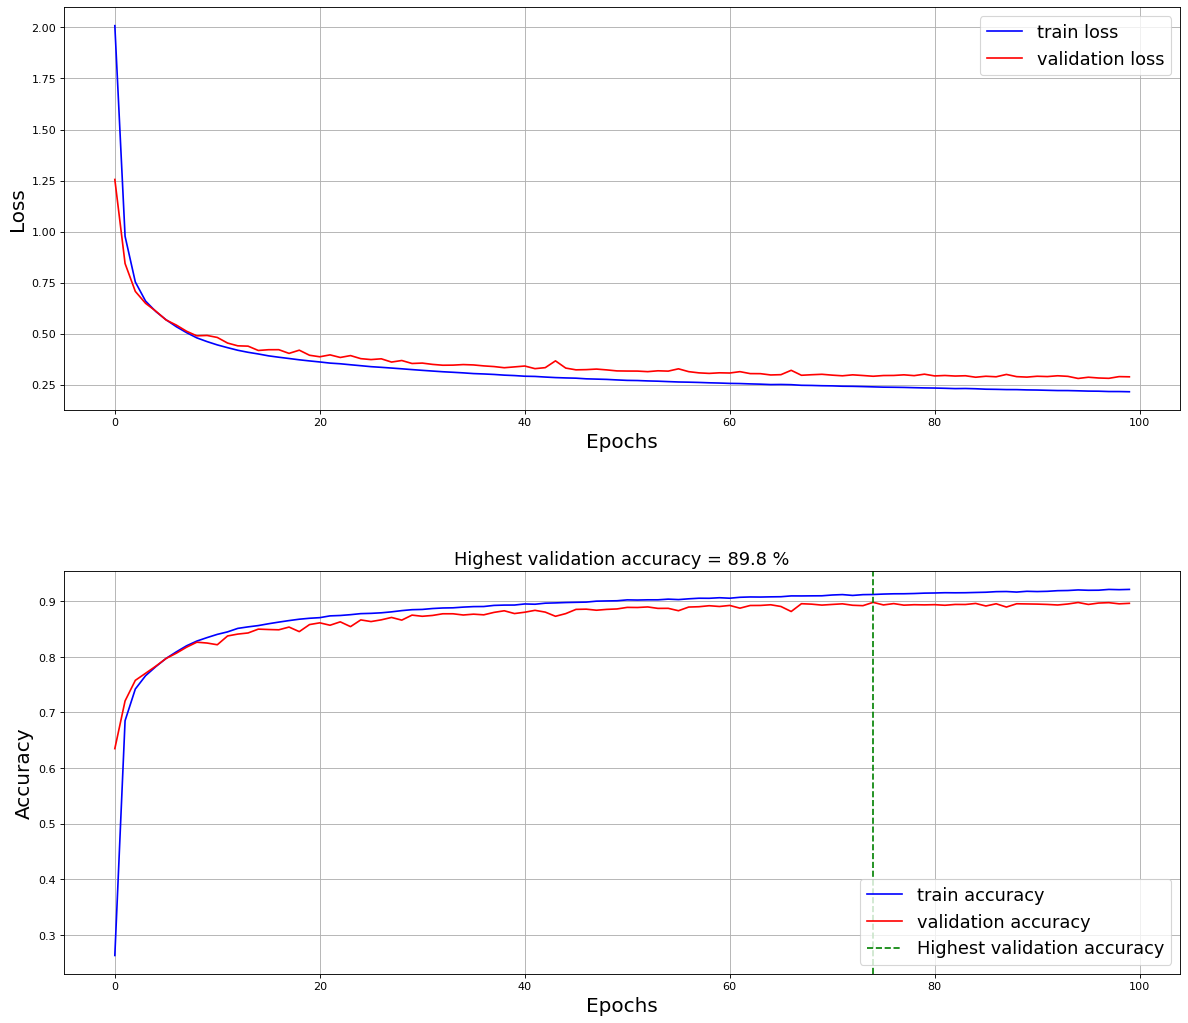

In [12]:
# Plot the loss and the accuracy in training and validation
#plt.figure()
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(2, 1, 1)
# plt.subplots_adjust(hspace=2)
ax.plot(train_loss, 'b', label='train loss')
ax.plot(val_loss, 'r', label='validation loss')
ax.grid()
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
ax.legend(loc='upper right', fontsize=16)

ax = plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0.4)
ax.plot(train_acc, 'b', label='train accuracy')
ax.plot(val_acc, 'r', label='validation accuracy')
ax.grid()
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
val_acc_max = np.max(val_acc)
val_acc_max_ind = np.argmax(val_acc)
plt.axvline(x=val_acc_max_ind, color='g', linestyle='--', label='Highest validation accuracy')
plt.title('Highest validation accuracy = %0.1f %%' % (val_acc_max*100), fontsize=16)
ax.legend(loc='lower right', fontsize=16)
plt.ion()

---
Let us study the accuracy per class on the validation dataset. We use the result from the epoch with highest validation accuracy.


In [13]:
ind = np.argmax(val_acc)
class_accuracy = val_confusion_matrix[:,:,ind]
for ii in range(len(classes)):
    acc = val_confusion_matrix[ii,ii,ind] / np.sum(val_confusion_matrix[ii,:,ind])
    print(f'Accuracy of {str(classes[ii]).ljust(15)}: {acc*100:.01f}%')

Accuracy of T-shirt / top  : 87.6%
Accuracy of Trouser        : 97.2%
Accuracy of Pullover       : 81.4%
Accuracy of Dress          : 88.8%
Accuracy of Coat           : 87.0%
Accuracy of Sandal         : 97.6%
Accuracy of Shirt          : 69.3%
Accuracy of Sneaker        : 95.7%
Accuracy of Bag            : 97.0%
Accuracy of Ankle boot     : 96.4%


---
In order to see how the network learns to distinguish the different classes as the training progresses, we can plot the confusion matrices after each second epoch as heatmaps.

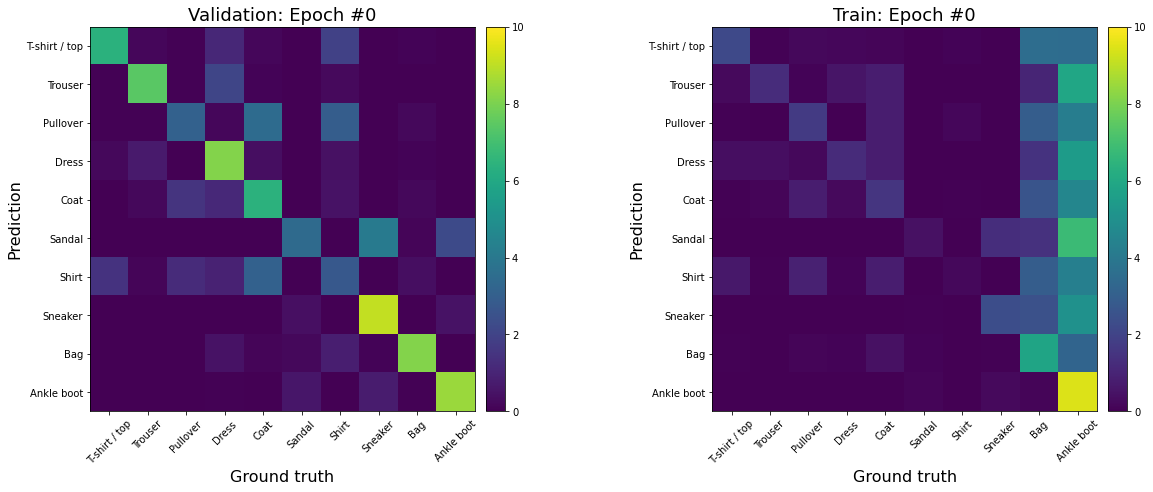

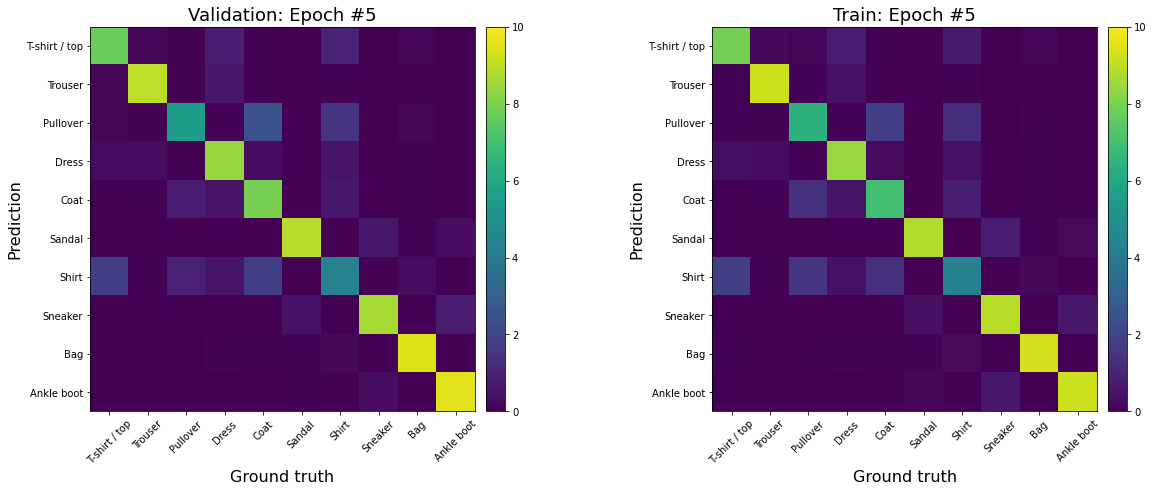

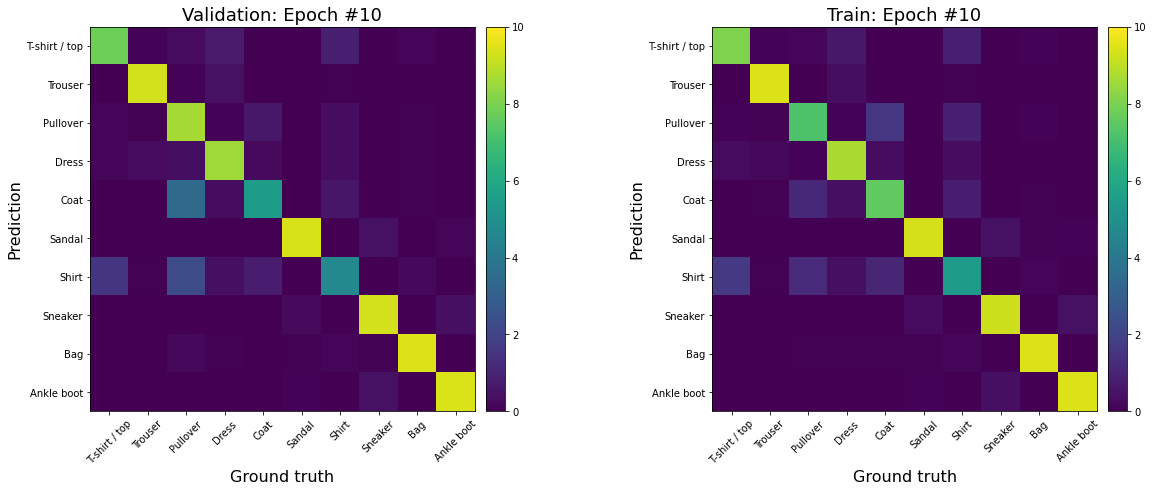

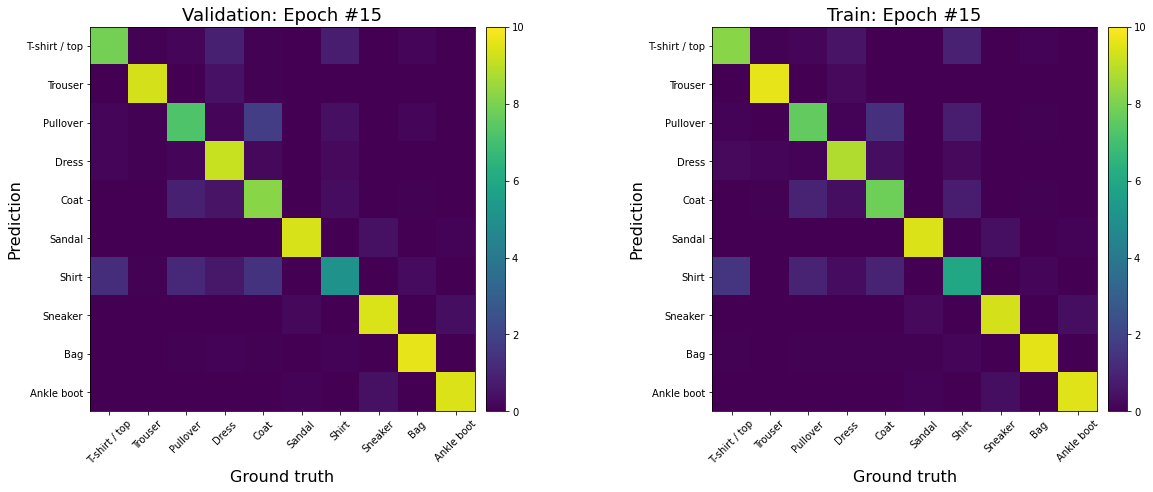

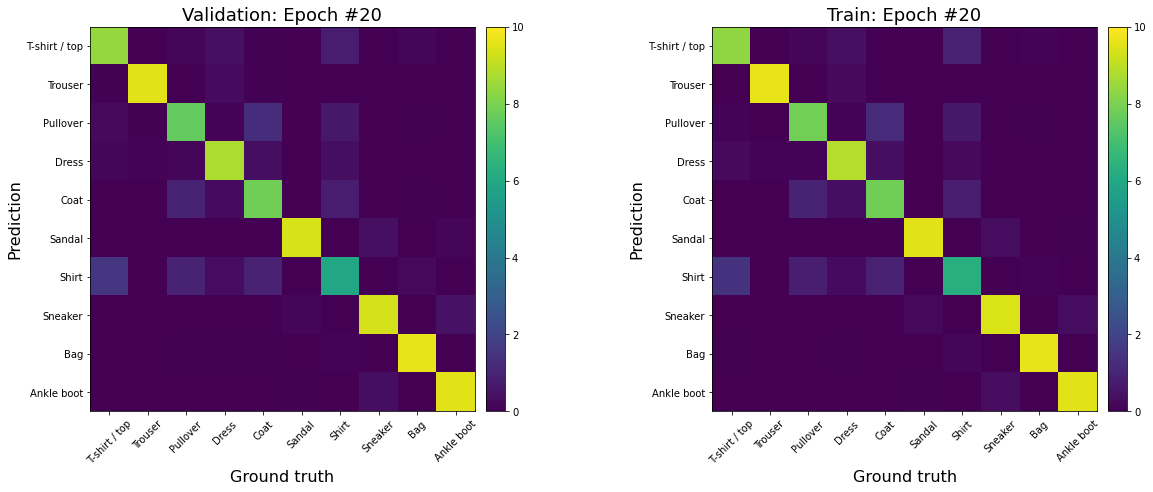

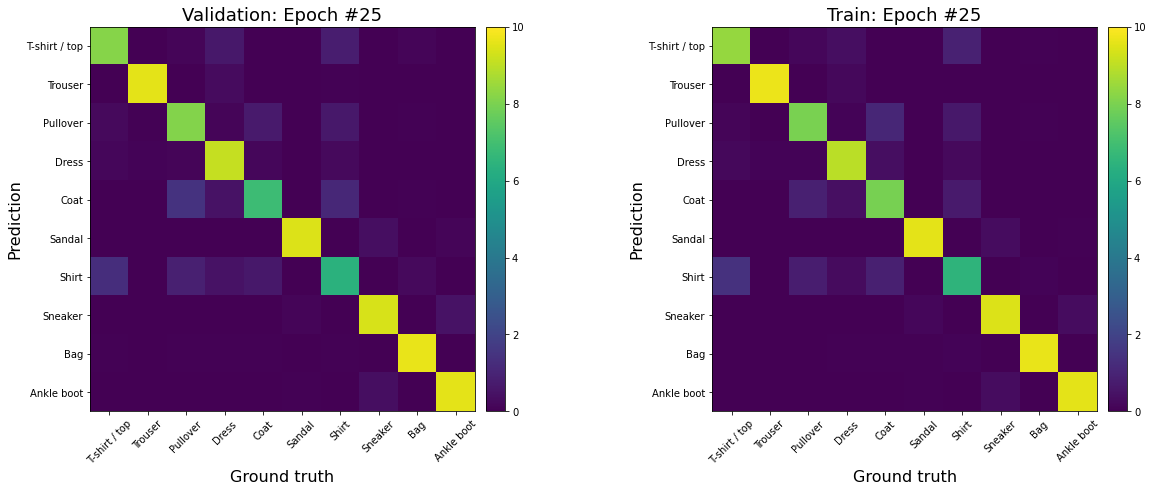

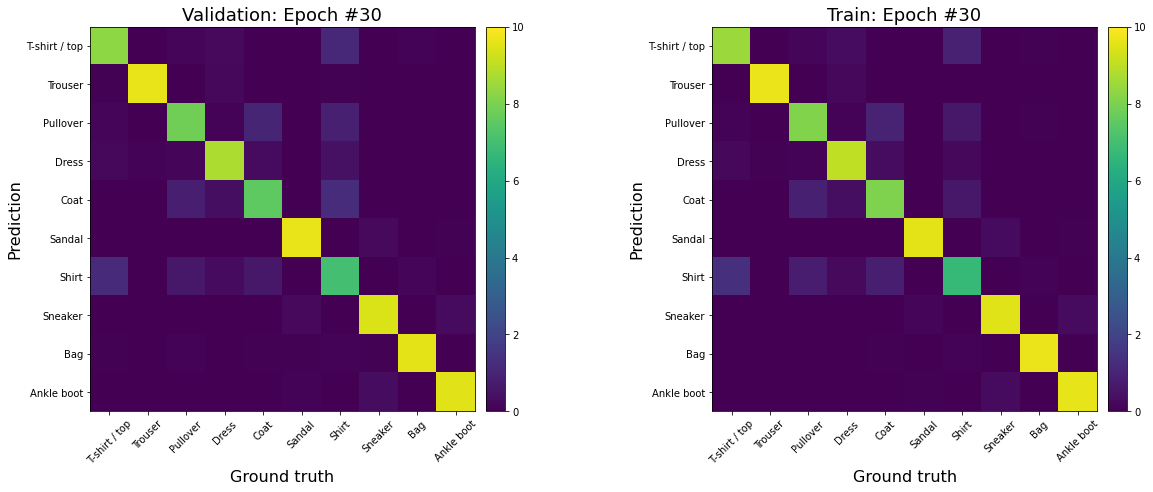

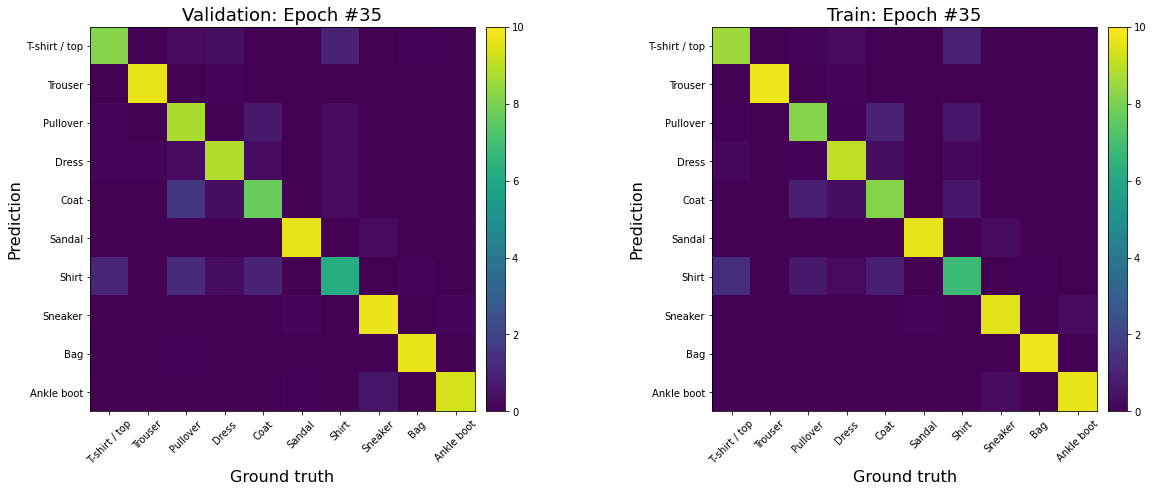

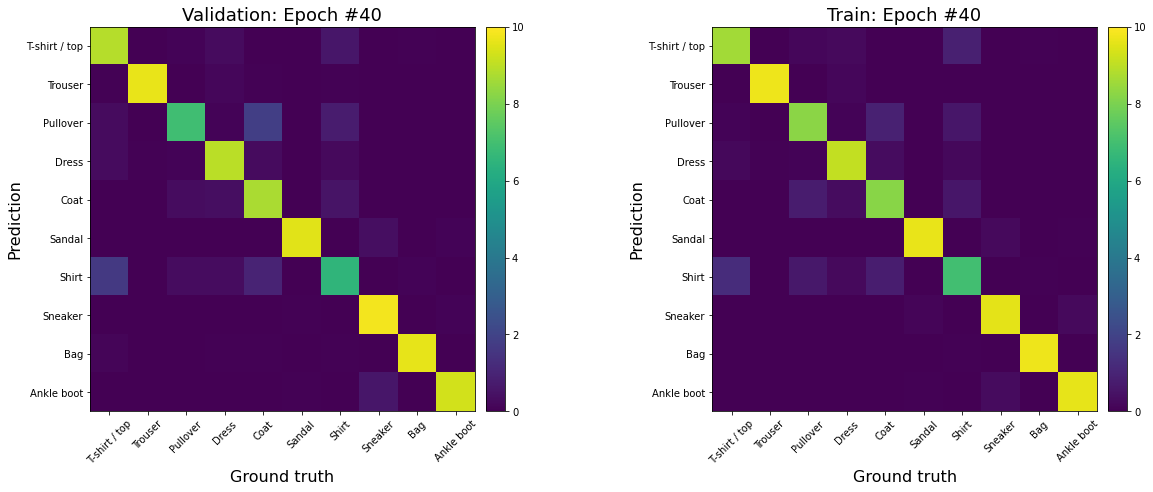

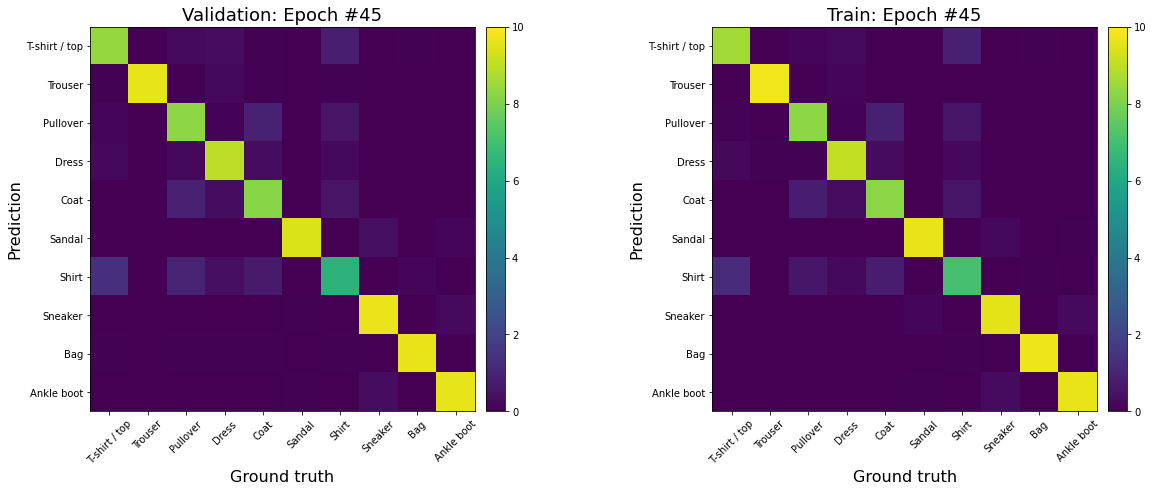

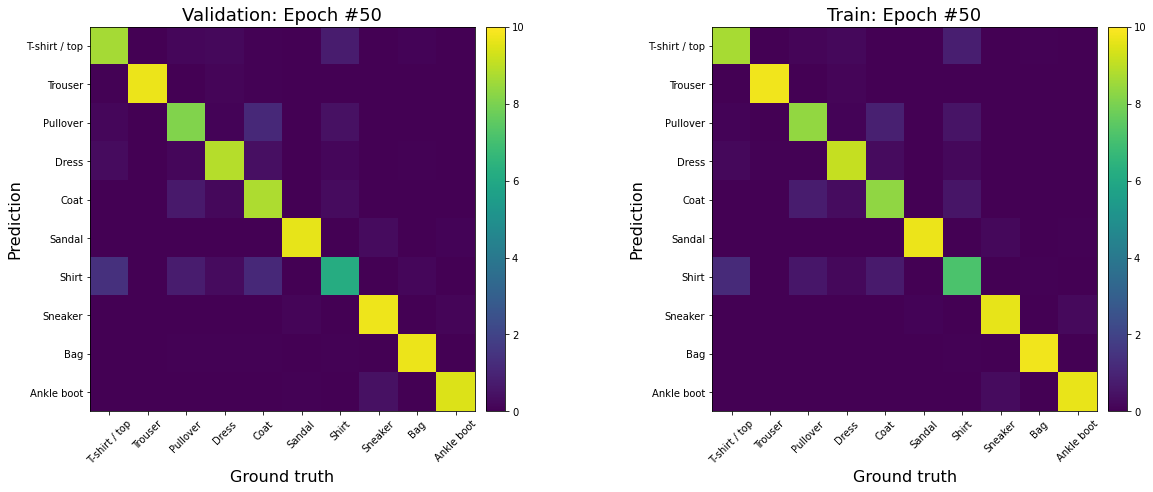

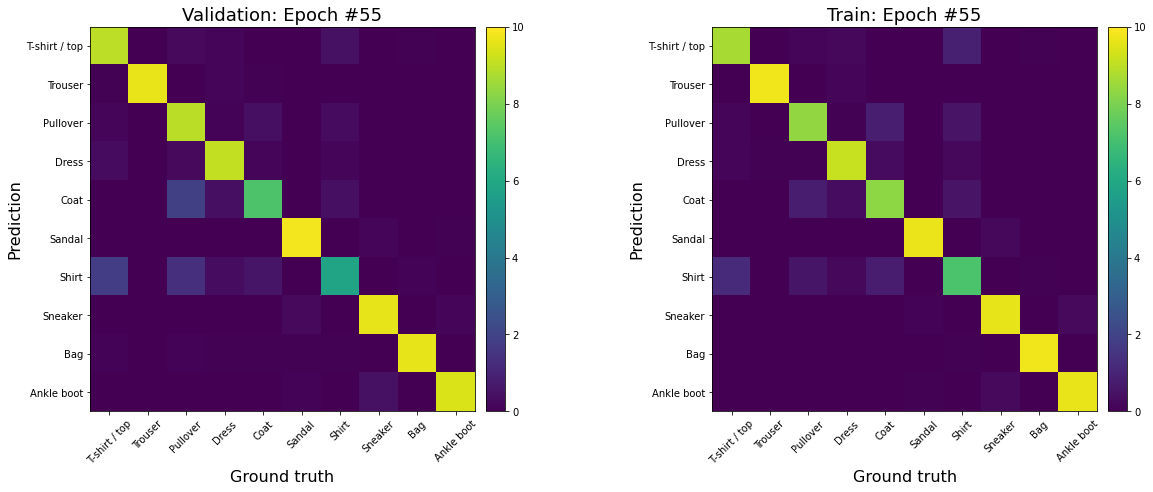

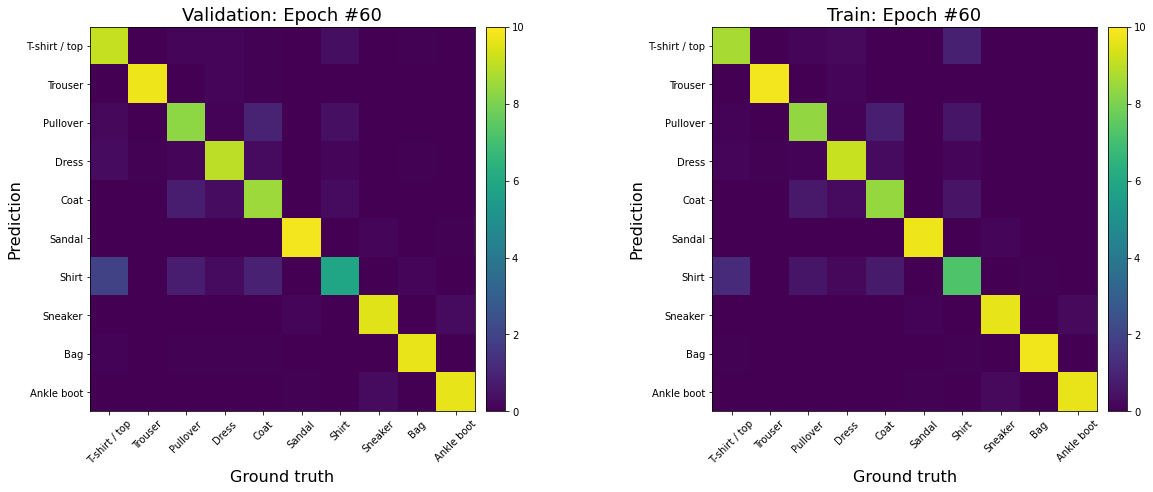

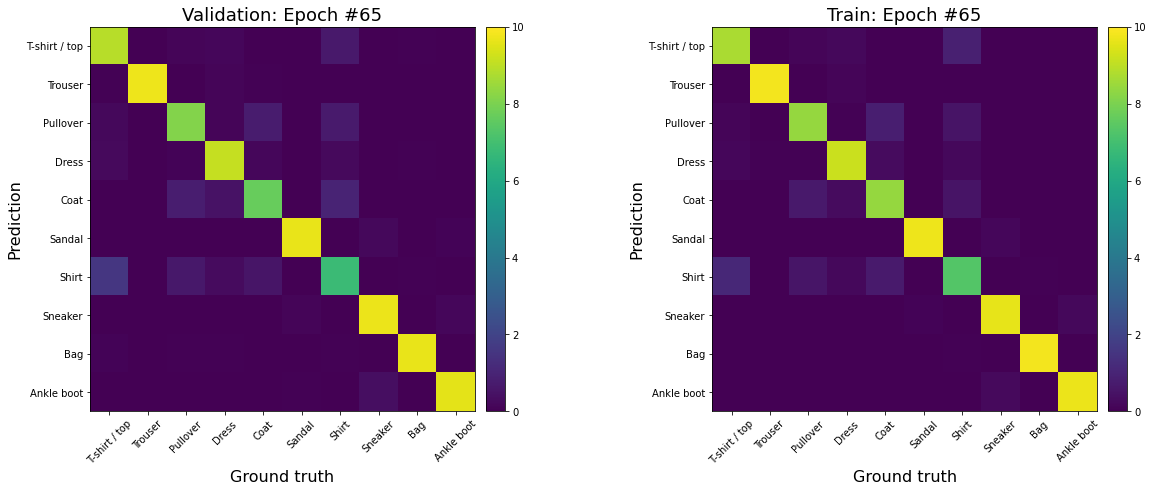

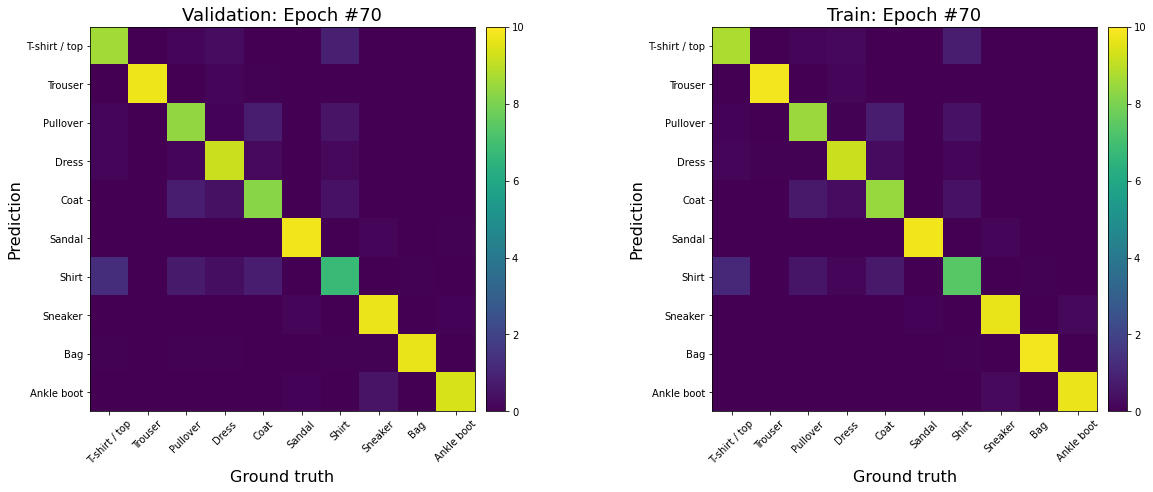

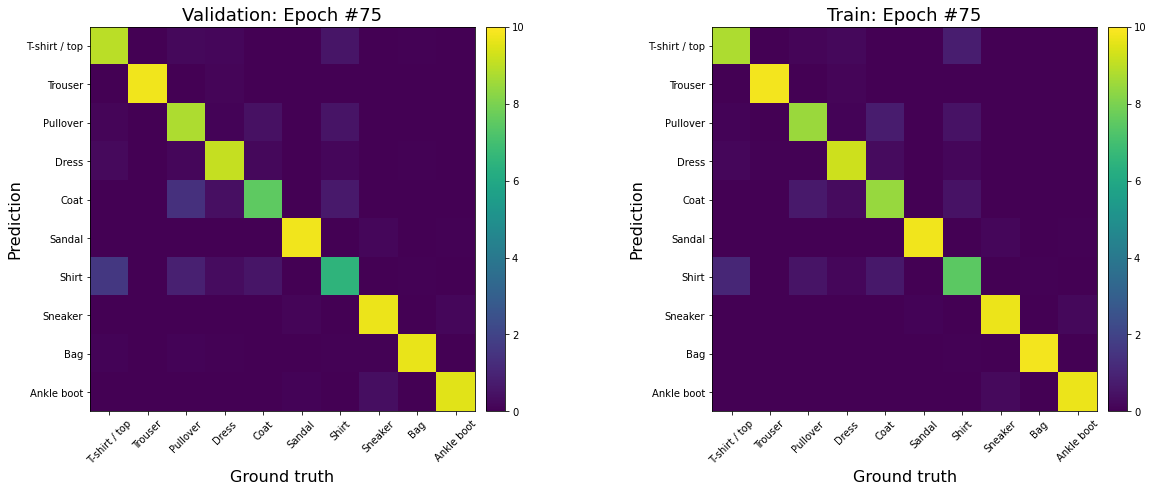

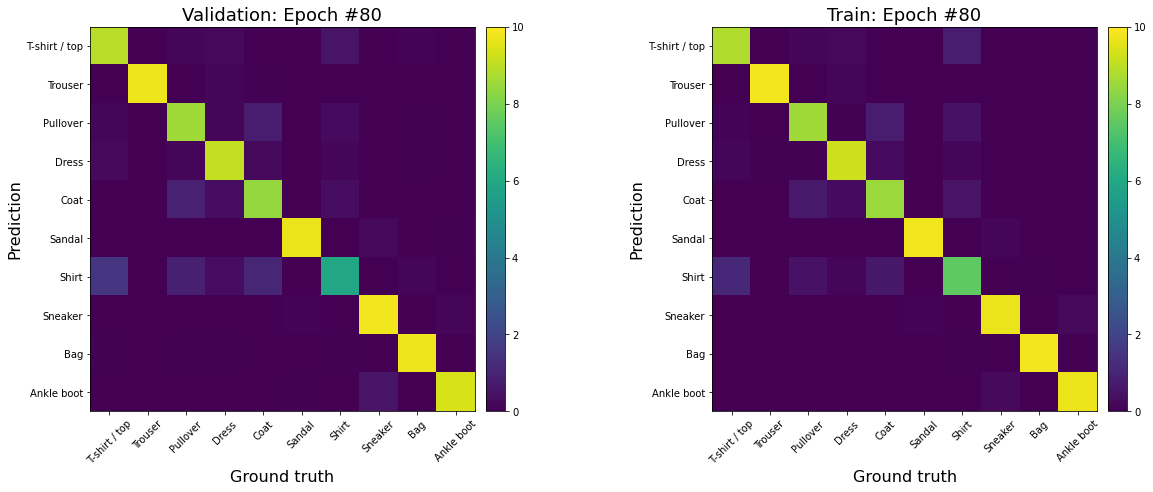

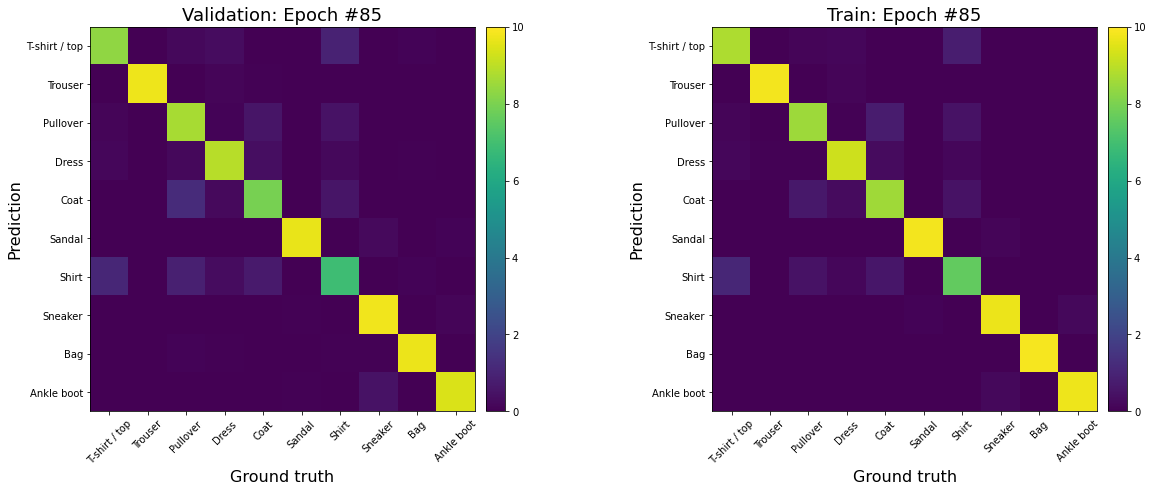

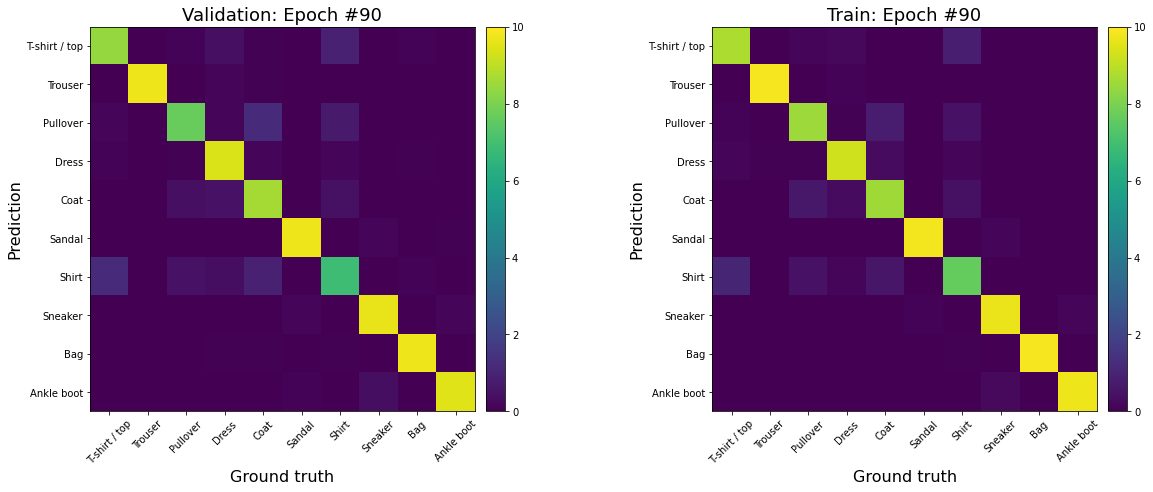

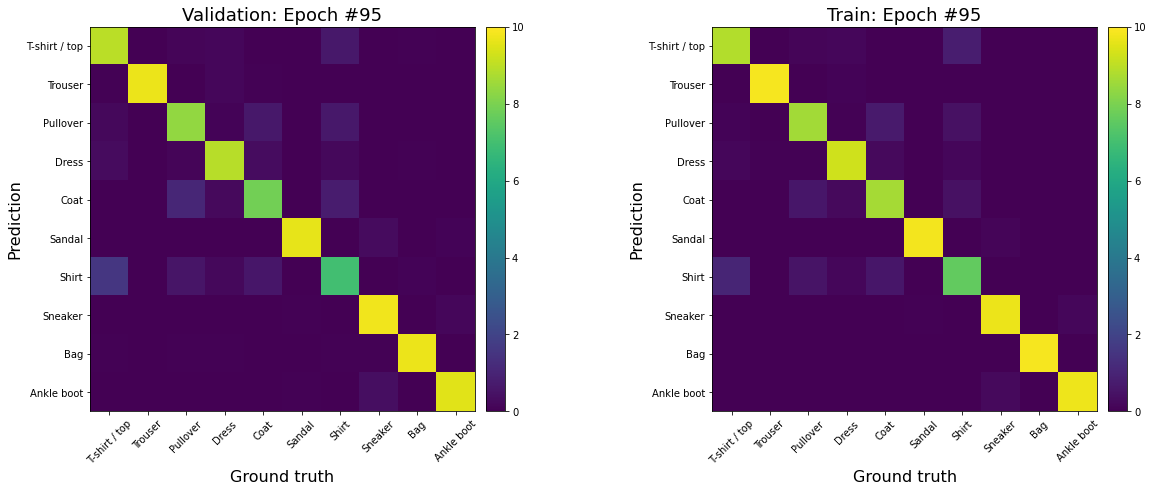

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epoch_step                  = 5    
set_colorbar_max_percentage = 10 
    
# Plot confusion matrices
ticks = np.linspace(0,9,10)
gridspec_kwargs = dict(top=0.9, bottom=0.1, left=0.0, right=0.9, wspace=0.5, hspace=0.2)
for i in range(0, config['epochs'], epoch_step):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16), gridspec_kw=gridspec_kwargs)
    im = ax1.imshow(val_confusion_matrix[:, :, i]*100)
    ax1.set_title(f'Validation: Epoch #{i}', fontsize=18)
    ax1.set_xticks(ticks=ticks)
    ax1.set_yticks(ticks=ticks)
    ax1.set_yticklabels(classes)
    im.set_clim(0.0, set_colorbar_max_percentage)
    ax1.set_xticklabels(classes, rotation=45)
    ax1.set_ylabel('Prediction', fontsize=16)
    ax1.set_xlabel('Ground truth', fontsize=16)
    divider = make_axes_locatable(ax1)
    cax     = divider.append_axes('right', size='5%', pad=0.15)
    f.colorbar(im, cax=cax, orientation='vertical')
    
    im = ax2.imshow(train_confusion_matrix[:, :, i]*100)
    ax2.set_title(f'Train: Epoch #{i}', fontsize=18)
    ax2.set_xticks(ticks=ticks)
    ax2.set_yticks(ticks=ticks)
    ax2.set_yticklabels(classes)
    im.set_clim(0.0, set_colorbar_max_percentage)
    ax2.set_xticklabels(classes, rotation=45)
    ax2.set_ylabel('Prediction', fontsize=16)
    ax2.set_xlabel('Ground truth', fontsize=16)
    divider = make_axes_locatable(ax2)
    cax     = divider.append_axes('right', size='5%', pad=0.15)
    f.colorbar(im, cax=cax, orientation='vertical')    